In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")

In [9]:
raw_csv_data=pd.read_csv("Index2018.csv")

In [10]:
df_comp=raw_csv_data.copy()
df_comp.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


In [11]:
df_comp.date=pd.to_datetime(df_comp.date,dayfirst=True)
df_comp.set_index("date",inplace=True)
df_comp=df_comp.asfreq("b")
df_comp=df_comp.fillna(method="ffill") #fill the null values forward fill technique

size=int(len(df_comp)*0.8)  #whatever dataset given we will take 1st 80% of that as training data
df,df_test=df_comp.iloc[:size],df_comp.iloc[size:]
df["market_value"]=df_comp.ftse #we will take only ftse column and put it as market value
#df.market_value.pct_change(1)
del df_comp["spx"]
del df_comp["dax"]
del df_comp["ftse"]
del df_comp["nikkei"]

df["returns"]=df.market_value.pct_change(1).mul(100) #pct change(1)show period that is 1 day in our case
df=df.iloc[1:]

In [12]:
df.head()

,spx,dax,ftse,nikkei,market_value,returns
date,,,,,,
1994-01-10,475.27,2225.00,3440.58,18443.44,3440.58,-0.156704
1994-01-11,474.13,2228.10,3413.77,18485.25,3413.77,-0.779229
1994-01-12,474.17,2182.06,3372.02,18793.88,3372.02,-1.222988
1994-01-13,472.47,2142.37,3360.01,18577.26,3360.01,-0.356166
1994-01-14,474.91,2151.05,3400.56,18973.70,3400.56,1.206842


In [13]:
df["returns"].head() #here negative values shows loss and positive shows gain

date
1994-01-10   -0.156704
1994-01-11   -0.779229
1994-01-12   -1.222988
1994-01-13   -0.356166
1994-01-14    1.206842
Freq: B, Name: returns, dtype: float64

# The DF_Test

In [14]:
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts

In [15]:
sts.adfuller(df.returns) #here p value is 7.798e-24 equal to zero than data is stationary

(-12.770265719497258,
 7.798058336037547e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 15696.767245697501)

# LLR

In [16]:
def LLR_test(mod_1,mod_2,DF=1):
    L1=mod_1.fit().llf
    L2=mod_2.fit().llf
    LR=(2*(L2-L1))
    p=chi2.sf(LR,DF).round(3)
    return p

# this is the model to compare 2 model 1 and 2  from model 2 to 1 is there any significance improvement or not idf there is improvement we reject  null hypothysis

In [17]:
import statsmodels.graphics.tsaplots as sgt

# ACF and PACF for Returns

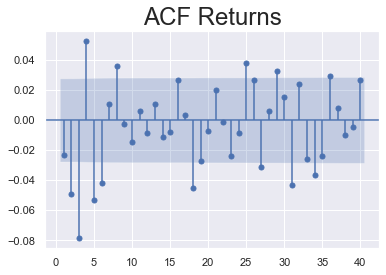

In [18]:
sgt.plot_acf(df.returns,lags=40,zero=False)
plt.title("ACF Returns",size=24)
plt.show()

#here dark  region is +2se and -2se we will consider only those lags which is out  of this dark region

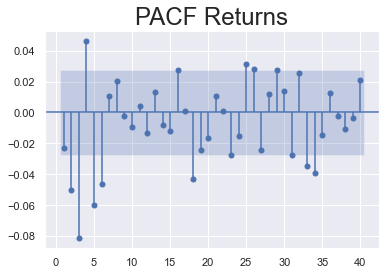

In [19]:
sgt.plot_pacf(df.returns,lags=40,zero=False,method=("ols"))
plt.title("PACF Returns",size=24)
plt.show()

# 6 is regionable here best model is AR(5) or AR(6)

In [20]:
from statsmodels.tsa.arima_model import ARMA

# ARMA for Returns

In [22]:
model_ar_6_ma_6=ARMA(df.market_value,order=(6,6))
results_ar_6_ma_6=model_ar_6_ma_6.fit(start_ar_lags=11)
results_ar_6_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                     ARMA(6, 6)   Log Likelihood              -27582.934
Method:                       css-mle   S.D. of innovations             58.855
Date:                Wed, 06 Sep 2023   AIC                          55193.867
Time:                        15:17:43   BIC                          55285.164
Sample:                    01-10-1994   HQIC                         55225.859
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.9795    568.732      8.950      0.000    3975.286    6204.673
ar.L1.market_value     1.9269      0.032     59.779      0.000       1.864       1.990
ar.L2.market_value    -1.7356      0.040    -43.305      0.000      -1.814      -1.657
ar.L3.market_value     1.2680      0.034     36.827      0.000       1.200       1.335
ar.L4.market_value    -0.2376      0.154     -1.541      0.123      -0.540       0.065
ar.L5.market_value    -0.4056      0.162     -2.511      0.012      -0.722      -0.089
ar.L6.market_value     0.1835      0.049      3.757      0.000       0.088       0.279
ma.L1.market_value    -0.9480      0.035    -26.973      0.000      -1.017      -0.879
ma.L2.market_value     0.7802      0.032     24.215      0.000       0.717       0.843
ma.L3.market_value    -0.5085      0.031    -16.317      0.000      -0.570      -0.447
ma.L4.market_value    -0.1560      0.155     -1.007      0.314      -0.460       0.148
ma.L5.market_value     0.0948      0.057      1.673      0.094      -0.016       0.206
ma.L6.market_value     0.0670      0.024      2.840      0.005       0.021       0.113
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0857           -1.0501j            1.0536           -0.2370
AR.2            0.0857           +1.0501j            1.0536            0.2370
AR.3           -2.0270           -0.0000j            2.0270           -0.5000
AR.4            1.0011           -0.0000j            1.0011           -0.0000
AR.5            1.5323           -0.2664j            1.5553           -0.0274
AR.6            1.5323           +0.2664j            1.5553            0.0274
MA.1            0.1028           -1.0611j            1.0661           -0.2346
MA.2            0.1028           +1.0611j            1.0661            0.2346
MA.3            1.3633           -0.2794j            1.3916           -0.0322
MA.4            1.3633           +0.2794j            1.3916            0.0322
MA.5           -2.1737           -1.4350j            2.6046           -0.4071
MA.6           -2.1737           +1.4350j            2.6046            0.4071
-----------------------------------------------------------------------------
"""

In [23]:
model_ar_5_ma_6=ARMA(df.market_value,order=(5,6))
results_ar_5_ma_6=model_ar_5_ma_6.fit(start_ar_lags=7)
results_ar_5_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                     ARMA(5, 6)   Log Likelihood              -27582.864
Method:                       css-mle   S.D. of innovations             58.854
Date:                Wed, 06 Sep 2023   AIC                          55191.728
Time:                        15:19:56   BIC                          55276.504
Sample:                    01-10-1994   HQIC                         55221.435
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.9786    581.889      8.747      0.000    3949.498    6230.459
ar.L1.market_value     1.3589      0.177      7.693      0.000       1.013       1.705
ar.L2.market_value    -1.1294      0.236     -4.784      0.000      -1.592      -0.667
ar.L3.market_value     0.9151      0.228      4.020      0.000       0.469       1.361
ar.L4.market_value     0.0155      0.203      0.076      0.939      -0.382       0.413
ar.L5.market_value    -0.1613      0.119     -1.353      0.176      -0.395       0.072
ma.L1.market_value    -0.3801      0.177     -2.146      0.032      -0.727      -0.033
ma.L2.market_value     0.7294      0.125      5.840      0.000       0.485       0.974
ma.L3.market_value    -0.2201      0.152     -1.447      0.148      -0.518       0.078
ma.L4.market_value    -0.1387      0.114     -1.216      0.224      -0.362       0.085
ma.L5.market_value    -0.0879      0.017     -5.324      0.000      -0.120      -0.056
ma.L6.market_value     0.0266      0.023      1.133      0.257      -0.019       0.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0917           -1.0418j            1.0459           -0.2360
AR.2            0.0917           +1.0418j            1.0459            0.2360
AR.3            1.0010           -0.0000j            1.0010           -0.0000
AR.4            1.8969           -0.0000j            1.8969           -0.0000
AR.5           -2.9853           -0.0000j            2.9853           -0.5000
MA.1            0.1071           -1.0488j            1.0542           -0.2338
MA.2            0.1071           +1.0488j            1.0542            0.2338
MA.3           -1.5349           -1.5156j            2.1571           -0.3760
MA.4           -1.5349           +1.5156j            2.1571            0.3760
MA.5            1.5915           -0.0000j            1.5915           -0.0000
MA.6            4.5710           -0.0000j            4.5710           -0.0000
-----------------------------------------------------------------------------
"""

In [26]:
print("ARMA(5,6):  \t LL=",results_ar_5_ma_6.llf," \t AIC=", results_ar_5_ma_6.aic)
print("ARMA(6,6):  \t LL=",results_ar_6_ma_6.llf," \t AIC=", results_ar_6_ma_6.aic)

AIC is smaller  is better

ARMA(5,6):  	 LL= -27582.864216696948  	 AIC= 55191.728433393895
ARMA(6,6):  	 LL= -27582.933685595548  	 AIC= 55193.867371191096


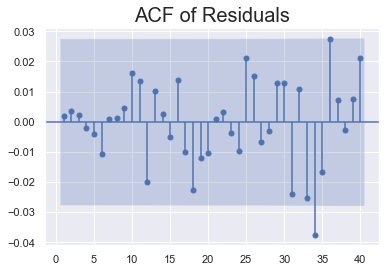

In [28]:
df["res_ar_5_ma_6"]=results_ar_5_ma_6.resid
sgt.plot_acf(df.res_ar_5_ma_6,zero=False,lags=40)
plt.title("ACF of Residuals",size=20)
plt.show()

In [29]:
#there is no correlation between residuals